# Predicting Community dynamics of SARS-COV-2 infection using wastewater in Scotland

 Importing libraries

In [1]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import pandas as pd
#import pmdarima as pm
from patsy import dmatrices
import statsmodels
import statsmodels.graphics.tsaplots as tsa
from statsmodels.regression import linear_model
from matplotlib import pyplot as plt
#from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import numpy as np
import math
import pmdarima
import seaborn as sns

from pmdarima.arima import ADFTest
from math import log
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller



from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
import ewstools

from scipy.stats import kendalltau
from pylab import rcParams
import seaborn as sb
from scipy import stats
from pygam import LogisticGAM
from plotly.subplots import make_subplots
from numpy import asarray
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

Importing file

In [2]:
df = pd.read_csv('clean_data.csv', header=0)
df

datevar                         HBName    rna_value  DailyPositive  \
0      28-May-20      NHS Dumfries and Galloway       0.0000              0   
1      28-May-20                       NHS Fife       0.0000              2   
2      28-May-20                   NHS Grampian       0.0000              2   
3      28-May-20  NHS Greater Glasgow and Clyde    2192.0000             13   
4      28-May-20                NHS Lanarkshire       0.0000             10   
...          ...                            ...          ...            ...   
10355  26-Jun-22                    NHS Lothian  182603.5451              0   
10356  26-Jun-22                     NHS Orkney   84778.0000              0   
10357  26-Jun-22                   NHS Shetland   15262.0000              0   
10358  26-Jun-22                    NHS Tayside   85966.0000              0   
10359  26-Jun-22              NHS Western Isles  139055.0000              0   

       CumulativePositive  DailyDeaths  CumulativeDeaths  CrudeRateDeaths  \
0                     285          0.0              40.0        26.974172   
1                     908          2.0             121.0        32.341699   
2                    1378          1.0             144.0        24.592264   
3                    4705          5.0             725.0        61.169046   
4                    2578          2.0             333.0        50.305154   
...                   ...          ...               ...              ...   
10355              336243          NaN               NaN              NaN   
10356                5774          NaN               NaN              NaN   
10357                7197          NaN               NaN              NaN   
10358              141374          NaN               NaN              NaN   
10359                8370          NaN               NaN              NaN   

       PositiveTests  PositivePillar1  ...  NHS_Forth_Valley  NHS_Grampian  \
0                  0              NaN  ...                 0             0   
1                  3              3.0  ...                 0             0   
2                  2              2.0  ...                 0             1   
3                 35             14.0  ...                 0             0   
4                 21             13.0  ...                 0             0   
...              ...              ...  ...               ...           ...   
10355              0              NaN  ...                 0             0   
10356              0              NaN  ...                 0             0   
10357              0              NaN  ...                 0             0   
10358              0              NaN  ...                 0             0   
10359              0              NaN  ...                 0             0   

       NHS_Greater_Glasgow_and_Clyde  NHS_Highland  NHS_Lanarkshire  \
0                                  0             0                0   
1                                  0             0                0   
2                                  0             0                0   
3                                  1             0                0   
4                                  0             0                1   
...                              ...           ...              ...   
10355                              0             0                0   
10356                              0             0                0   
10357                              0             0                0   
10358                              0             0                0   
10359                              0             0                0   

       NHS_Lothian  NHS_Orkney  NHS_Shetland  NHS_Tayside  NHS_Western_Isles  
0                0           0             0            0                  0  
1                0           0             0            0                  0  
2                0           0             0            0                  0  
3                0           

Considering 7 lag values of RNA and daily positive cases

In [3]:
df['rna_lag_1'] = df['rna_value'].shift(1)
df['rna_lag_2'] = df['rna_value'].shift(2)
df['rna_lag_3'] = df['rna_value'].shift(3)
df['rna_lag_4'] = df['rna_value'].shift(4)
df['rna_lag_5'] = df['rna_value'].shift(5)
df['rna_lag_6'] = df['rna_value'].shift(6)
df['rna_lag_7'] = df['rna_value'].shift(7)
df['DailyPositive_lag_1'] = df['DailyPositive'].shift(1)
df['DailyPositive_lag_2'] = df['DailyPositive'].shift(2)
df['DailyPositive_lag_3'] = df['DailyPositive'].shift(3)
df['DailyPositive_lag_4'] = df['DailyPositive'].shift(4)
df['DailyPositive_lag_5'] = df['DailyPositive'].shift(5)
df['DailyPositive_lag_6'] = df['DailyPositive'].shift(6)
df['DailyPositive_lag_7'] = df['DailyPositive'].shift(7)
df

datevar                         HBName    rna_value  DailyPositive  \
0      28-May-20      NHS Dumfries and Galloway       0.0000              0   
1      28-May-20                       NHS Fife       0.0000              2   
2      28-May-20                   NHS Grampian       0.0000              2   
3      28-May-20  NHS Greater Glasgow and Clyde    2192.0000             13   
4      28-May-20                NHS Lanarkshire       0.0000             10   
...          ...                            ...          ...            ...   
10355  26-Jun-22                    NHS Lothian  182603.5451              0   
10356  26-Jun-22                     NHS Orkney   84778.0000              0   
10357  26-Jun-22                   NHS Shetland   15262.0000              0   
10358  26-Jun-22                    NHS Tayside   85966.0000              0   
10359  26-Jun-22              NHS Western Isles  139055.0000              0   

       CumulativePositive  DailyDeaths  CumulativeDeaths  CrudeRateDeaths  \
0                     285          0.0              40.0        26.974172   
1                     908          2.0             121.0        32.341699   
2                    1378          1.0             144.0        24.592264   
3                    4705          5.0             725.0        61.169046   
4                    2578          2.0             333.0        50.305154   
...                   ...          ...               ...              ...   
10355              336243          NaN               NaN              NaN   
10356                5774          NaN               NaN              NaN   
10357                7197          NaN               NaN              NaN   
10358              141374          NaN               NaN              NaN   
10359                8370          NaN               NaN              NaN   

       PositiveTests  PositivePillar1  ...     rna_lag_5     rna_lag_6  \
0                  0              NaN  ...           NaN           NaN   
1                  3              3.0  ...           NaN           NaN   
2                  2              2.0  ...           NaN           NaN   
3                 35             14.0  ...           NaN           NaN   
4                 21             13.0  ...           NaN           NaN   
...              ...              ...  ...           ...           ...   
10355              0              NaN  ...  166173.06550  184674.94170   
10356              0              NaN  ...   46868.12344  166173.06550   
10357              0              NaN  ...   71224.27232   46868.12344   
10358              0              NaN  ...   59069.61810   71224.27232   
10359              0              NaN  ...   67380.00000   59069.61810   

          rna_lag_7  DailyPositive_lag_1  DailyPositive_lag_2  \
0               NaN                  NaN                  NaN   
1               NaN                  0.0                  NaN   
2               NaN                  2.0                  0.0   
3               NaN                  2.0                  2.0   
4               NaN                 13.0                  2.0   
...             ...                  ...                  ...   
10355  115499.00000                  0.0                  0.0   
10356  184674.94170                  0.0                  0.0   
10357  166173.06550                  0.0                  0.0   
10358   46868.12344                  0.0                  0.0   
10359   71224.27232                  0.0                  0.0   

       DailyPositive_lag_3  DailyPositive_lag_4  DailyPositive_lag_5  \
0                      NaN                  NaN                  NaN   
1                      NaN                  NaN                  NaN   
2                      NaN                  NaN                  NaN   
3                      0.0                  NaN                  NaN   
4                      2.0                  0.0                  NaN   
...                    ...       

Indexing by Date variable

In [4]:
df['DateTimeIndex']= pd.to_datetime(df['datevar'])
df = df.set_index(keys=['DateTimeIndex'])
df
print(df)
print(df.describe())

                 datevar                         HBName    rna_value  \
DateTimeIndex                                                          
2020-05-28     28-May-20      NHS Dumfries and Galloway       0.0000   
2020-05-28     28-May-20                       NHS Fife       0.0000   
2020-05-28     28-May-20                   NHS Grampian       0.0000   
2020-05-28     28-May-20  NHS Greater Glasgow and Clyde    2192.0000   
2020-05-28     28-May-20                NHS Lanarkshire       0.0000   
...                  ...                            ...          ...   
2022-06-26     26-Jun-22                    NHS Lothian  182603.5451   
2022-06-26     26-Jun-22                     NHS Orkney   84778.0000   
2022-06-26     26-Jun-22                   NHS Shetland   15262.0000   
2022-06-26     26-Jun-22                    NHS Tayside   85966.0000   
2022-06-26     26-Jun-22              NHS Western Isles  139055.0000   

               DailyPositive  CumulativePositive  DailyDeaths  

Checking for missing values in RNA values, daily positive cases, cumulative cases and all the lag values

In [5]:
df.isin([np.nan, np.inf, -np.inf]).sum()

datevar                             0
HBName                              0
rna_value                           0
DailyPositive                       0
CumulativePositive                  0
DailyDeaths                       350
CumulativeDeaths                  350
CrudeRateDeaths                   350
PositiveTests                       0
PositivePillar1                  1974
PositivePillar2                  1974
FirstInfections                     0
FirstInfectionsCumulative           0
Reinfections                        0
ReinfectionsCumulative              0
PercentReinfections              1361
TotalTests                         13
TotalPillar1                       13
TotalPillar2                       13
weekday                             0
day                                 0
NHS_Borders                         0
NHS_Dumfries_and_Galloway           0
NHS_Fife                            0
NHS_Forth_Valley                    0
NHS_Grampian                        0
NHS_Greater_

Observing some missing values, 10 is added to all the values of RNA, daily cases and its lags and logarithmic functions of the corresponding value is taken to improve the model fitting by turning the residual normal-like

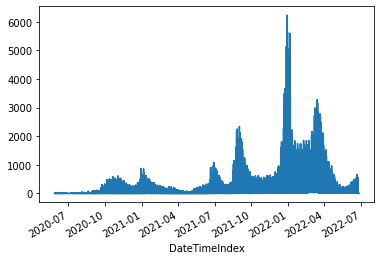

In [6]:
df['DailyPositive'].plot()
df['DailyPositive'] = np.log(3+df['DailyPositive'])
df['DailyPositive_lag_1'] = np.log(3+df['DailyPositive_lag_1'])
df['DailyPositive_lag_2'] = np.log(3+df['DailyPositive_lag_2'])
df['DailyPositive_lag_3'] = np.log(3+df['DailyPositive_lag_3'])
df['DailyPositive_lag_4'] = np.log(3+df['DailyPositive_lag_4'])
df['DailyPositive_lag_5'] = np.log(3+df['DailyPositive_lag_5'])
df['DailyPositive_lag_6'] = np.log(3+df['DailyPositive_lag_6'])
df['DailyPositive_lag_7'] = np.log(3+df['DailyPositive_lag_7'])
df['rna_value'] = np.log(10+df['rna_value'])
df['rna_lag_1'] = np.log(10+df['rna_lag_1'])
df['rna_lag_2'] = np.log(10+df['rna_lag_2'])
df['rna_lag_3'] = np.log(10+df['rna_lag_3'])
df['rna_lag_4'] = np.log(10+df['rna_lag_4'])
df['rna_lag_5'] = np.log(10+df['rna_lag_5'])
df['rna_lag_6'] = np.log(10+df['rna_lag_6'])
df['rna_lag_7'] = np.log(10+df['rna_lag_7'])

In [7]:
df

datevar                         HBName  rna_value  \
DateTimeIndex                                                        
2020-05-28     28-May-20      NHS Dumfries and Galloway   2.302585   
2020-05-28     28-May-20                       NHS Fife   2.302585   
2020-05-28     28-May-20                   NHS Grampian   2.302585   
2020-05-28     28-May-20  NHS Greater Glasgow and Clyde   7.697121   
2020-05-28     28-May-20                NHS Lanarkshire   2.302585   
...                  ...                            ...        ...   
2022-06-26     26-Jun-22                    NHS Lothian  12.115127   
2022-06-26     26-Jun-22                     NHS Orkney  11.347909   
2022-06-26     26-Jun-22                   NHS Shetland   9.633776   
2022-06-26     26-Jun-22                    NHS Tayside  11.361823   
2022-06-26     26-Jun-22              NHS Western Isles  11.842697   

               DailyPositive  CumulativePositive  DailyDeaths  \
DateTimeIndex                                                   
2020-05-28          1.098612                 285          0.0   
2020-05-28          1.609438                 908          2.0   
2020-05-28          1.609438                1378          1.0   
2020-05-28          2.772589                4705          5.0   
2020-05-28          2.564949                2578          2.0   
...                      ...                 ...          ...   
2022-06-26          1.098612              336243          NaN   
2022-06-26          1.098612                5774          NaN   
2022-06-26          1.098612                7197          NaN   
2022-06-26          1.098612              141374          NaN   
2022-06-26          1.098612                8370          NaN   

               CumulativeDeaths  CrudeRateDeaths  PositiveTests  \
DateTimeIndex                                                     
2020-05-28                 40.0        26.974172              0   
2020-05-28                121.0        32.341699              3   
2020-05-28                144.0        24.592264              2   
2020-05-28                725.0        61.169046             35   
2020-05-28                333.0        50.305154             21   
...                         ...              ...            ...   
2022-06-26                  NaN              NaN              0   
2022-06-26                  NaN              NaN              0   
2022-06-26                  NaN              NaN              0   
2022-06-26                  NaN              NaN              0   
2022-06-26                  NaN              NaN              0   

               PositivePillar1  ...  rna_lag_5  rna_lag_6  rna_lag_7  \
DateTimeIndex                   ...                                    
2020-05-28                 NaN  ...        NaN        NaN        NaN   
2020-05-28                 3.0  ...        NaN        NaN        NaN   
2020-05-28                 2.0  ...        NaN        NaN        NaN   
2020-05-28                14.0  ...        NaN        NaN        NaN   
2020-05-28                13.0  ...        NaN        NaN        NaN   
...                        ...  ...        ...        ...        ...   
2022-06-26                 NaN  ...  12.020845  12.126407  11.657104   
2022-06-26                 NaN  ...  10.755306  12.020845  12.126407   
2022-06-26                 NaN  ...  11.173729  10.755306  12.020845   
2022-06-26                 NaN  ...  10.986641  11.173729  10.755306   
2022-06-26                 NaN  ...  11.118252  10.986641  11.173729   

               DailyPositive_lag_1  DailyPositive_lag_2  DailyPositive_lag_3  \
DateTimeIndex                                                                  
2020-05-28                     NaN                  NaN                  NaN   
2020-05-28                1.098612                  NaN                  NaN   
2020-05-28                1.609438             1.098612                  NaN   
2020-05-28                1.609438             1.60

## EDA

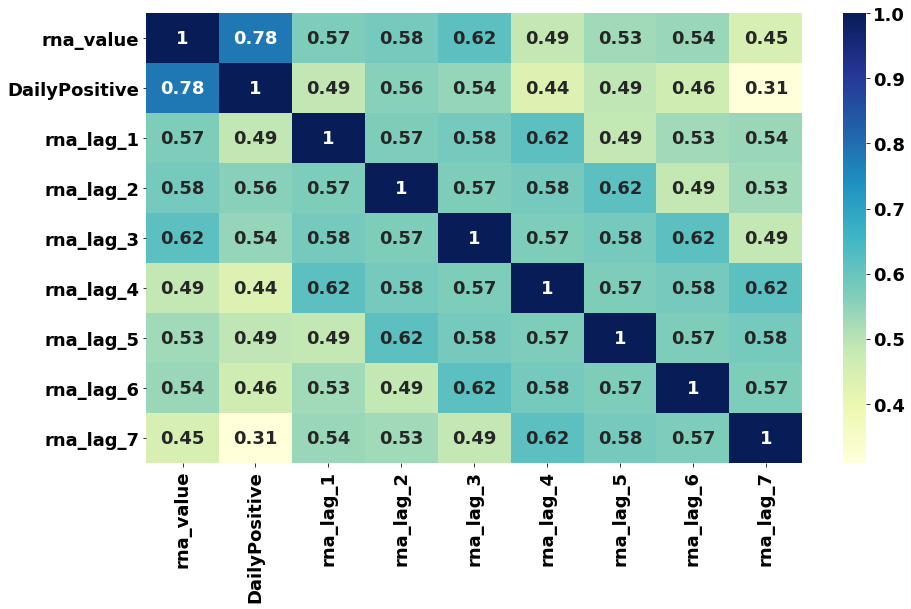

In [8]:
df1=df.iloc[:, [2,3,34,35,36,37,38,39,40]]
df1
corr = df1.corr(method='pearson')
corr
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
rcParams['figure.figsize'] = 14.7,8.27
sb.heatmap(corr, 
           xticklabels=corr.columns.values, 
          yticklabels=corr.columns.values, 
           cmap="YlGnBu",
          annot=True)
plt.savefig('heatmap1.png',bbox_inches='tight')


Plotting the RNA and daily cases by Health Board to determine the trend and possible outliers

In [9]:

a=px.line(df,x='datevar', y='rna_value',facet_col='HBName', facet_col_wrap=2,labels={
                     "rna_value": "rna"})
a.update_layout(yaxis_title="rna",font=dict(size=13))
a.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
a.write_image("Picture3_.png")
a.update_annotations(font_size=13)
a

In [10]:
b=px.line(df,x='datevar', y='DailyPositive',facet_col='HBName', facet_col_wrap=3,labels={
                     "DailyPositive": "Cases"})
#b.update_layout(font=dict(size=11))
b.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
b.write_image("Picture3_1.png")
#a.update_annotations(font_size=20)
b

In [11]:
# df.groupby(['datevar', 'HBName'])['DailyPositive'].sum().unstack().plot() 
# plt.xticks(rotation=90)
# plt.legend(bbox_to_anchor=(1,0.5) , loc='center left')
# plt.savefig('posbyhb.png',dpi=300,bbox_inches='tight')

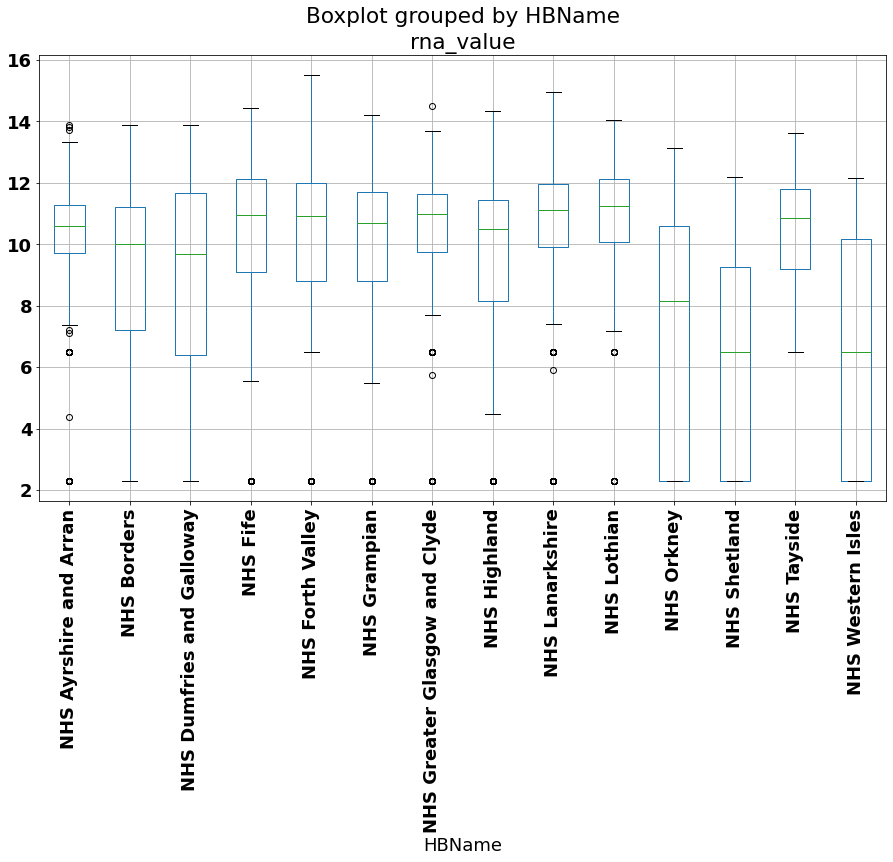

In [12]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
df.boxplot(column=['rna_value'],by='HBName')
# Rotate tick labels
plt.xticks(rotation=90)
#plt.autoscale()
# Display graph
plt.savefig('Picture3.png',bbox_inches='tight')

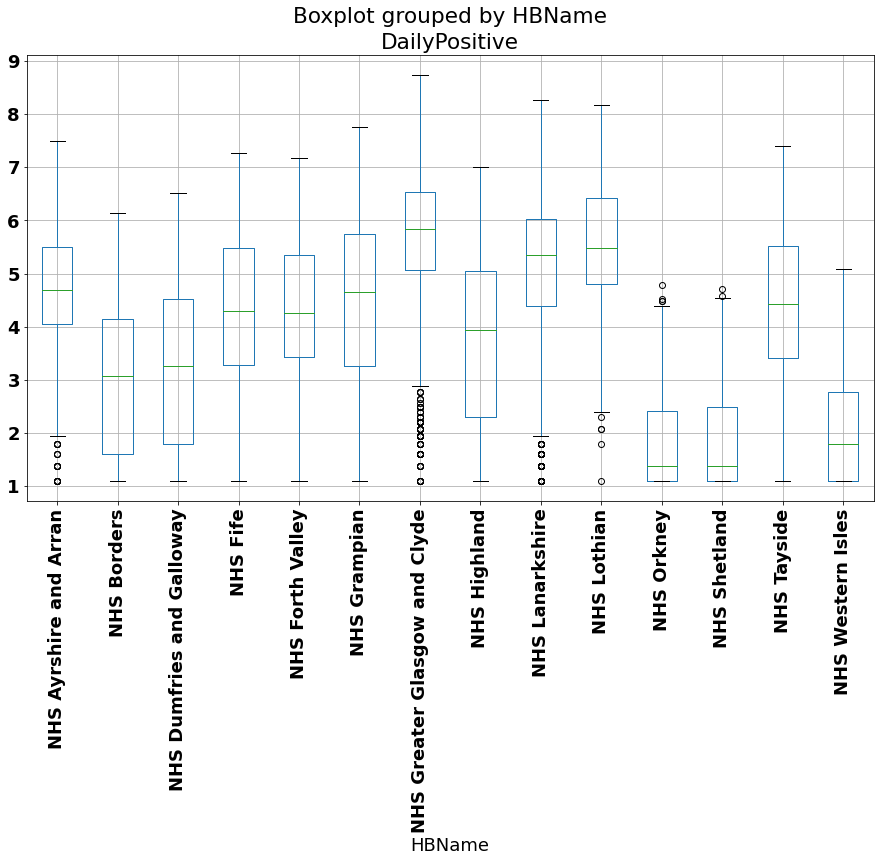

In [13]:
df.boxplot(column=['DailyPositive'],by='HBName')
# Rotate tick labels
plt.xticks(rotation=90)
#plt.autoscale()
# Display graph
plt.savefig('Picture3_1.png')

Observing the current dataframe with repeating date indices because of regional changes observed

In [14]:
df

datevar                         HBName  rna_value  \
DateTimeIndex                                                        
2020-05-28     28-May-20      NHS Dumfries and Galloway   2.302585   
2020-05-28     28-May-20                       NHS Fife   2.302585   
2020-05-28     28-May-20                   NHS Grampian   2.302585   
2020-05-28     28-May-20  NHS Greater Glasgow and Clyde   7.697121   
2020-05-28     28-May-20                NHS Lanarkshire   2.302585   
...                  ...                            ...        ...   
2022-06-26     26-Jun-22                    NHS Lothian  12.115127   
2022-06-26     26-Jun-22                     NHS Orkney  11.347909   
2022-06-26     26-Jun-22                   NHS Shetland   9.633776   
2022-06-26     26-Jun-22                    NHS Tayside  11.361823   
2022-06-26     26-Jun-22              NHS Western Isles  11.842697   

               DailyPositive  CumulativePositive  DailyDeaths  \
DateTimeIndex                                                   
2020-05-28          1.098612                 285          0.0   
2020-05-28          1.609438                 908          2.0   
2020-05-28          1.609438                1378          1.0   
2020-05-28          2.772589                4705          5.0   
2020-05-28          2.564949                2578          2.0   
...                      ...                 ...          ...   
2022-06-26          1.098612              336243          NaN   
2022-06-26          1.098612                5774          NaN   
2022-06-26          1.098612                7197          NaN   
2022-06-26          1.098612              141374          NaN   
2022-06-26          1.098612                8370          NaN   

               CumulativeDeaths  CrudeRateDeaths  PositiveTests  \
DateTimeIndex                                                     
2020-05-28                 40.0        26.974172              0   
2020-05-28                121.0        32.341699              3   
2020-05-28                144.0        24.592264              2   
2020-05-28                725.0        61.169046             35   
2020-05-28                333.0        50.305154             21   
...                         ...              ...            ...   
2022-06-26                  NaN              NaN              0   
2022-06-26                  NaN              NaN              0   
2022-06-26                  NaN              NaN              0   
2022-06-26                  NaN              NaN              0   
2022-06-26                  NaN              NaN              0   

               PositivePillar1  ...  rna_lag_5  rna_lag_6  rna_lag_7  \
DateTimeIndex                   ...                                    
2020-05-28                 NaN  ...        NaN        NaN        NaN   
2020-05-28                 3.0  ...        NaN        NaN        NaN   
2020-05-28                 2.0  ...        NaN        NaN        NaN   
2020-05-28                14.0  ...        NaN        NaN        NaN   
2020-05-28                13.0  ...        NaN        NaN        NaN   
...                        ...  ...        ...        ...        ...   
2022-06-26                 NaN  ...  12.020845  12.126407  11.657104   
2022-06-26                 NaN  ...  10.755306  12.020845  12.126407   
2022-06-26                 NaN  ...  11.173729  10.755306  12.020845   
2022-06-26                 NaN  ...  10.986641  11.173729  10.755306   
2022-06-26                 NaN  ...  11.118252  10.986641  11.173729   

               DailyPositive_lag_1  DailyPositive_lag_2  DailyPositive_lag_3  \
DateTimeIndex                                                                  
2020-05-28                     NaN                  NaN                  NaN   
2020-05-28                1.098612                  NaN                  NaN   
2020-05-28                1.609438             1.098612                  NaN   
2020-05-28                1.609438             1.60

# Analysis

Summing up the values corresponding to same date index to get a daily indexed data and creating a 95% train set and 5% test set

In [15]:
df=df.groupby(df.index).sum()
dataset_len = len(df)
split_index = round(dataset_len*0.95)
train_set_end_date = df.index[split_index]
df_train = df.loc[df.index <= train_set_end_date].copy()
df_test = df.loc[df.index > train_set_end_date].copy()
df_train

rna_value  DailyPositive  CumulativePositive  DailyDeaths  \
DateTimeIndex                                                               
2020-05-28      16.907462       9.655026                9854         10.0   
2020-05-29      23.188833       8.658693               11602          8.0   
2020-05-30      23.188833      10.316921               11622          2.0   
2020-05-31      23.188833       9.701065               11640          6.0   
2020-06-01      25.491418      12.347572               12033          2.0   
...                   ...            ...                 ...          ...   
2022-05-16     157.947298      55.392008             1943991         12.0   
2022-05-17     157.947298      53.712392             1945053          4.0   
2022-05-18     157.947298      52.396968             1945964          5.0   
2022-05-19     157.947298      51.921050             1946763         10.0   
2022-05-20     157.947298      50.273952             1947510          8.0   

               CumulativeDeaths  CrudeRateDeaths  PositiveTests  \
DateTimeIndex                                                     
2020-05-28               1363.0       195.382336             61   
2020-05-29               1567.0       243.641671             27   
2020-05-30               1569.0       243.943804             49   
2020-05-31               1575.0       244.894814             43   
2020-06-01               1642.0       265.504528             63   
...                         ...              ...            ...   
2022-05-16              12320.0      2656.904819           1493   
2022-05-17              12324.0      2657.429679           1516   
2022-05-18              12329.0      2658.188146           1299   
2022-05-19              12339.0      2660.603549           1159   
2022-05-20              12347.0      2661.975718           1106   

               PositivePillar1  PositivePillar2  FirstInfections  ...  \
DateTimeIndex                                                     ...   
2020-05-28                32.0             29.0               27  ...   
2020-05-29                18.0              9.0                9  ...   
2020-05-30                28.0             21.0               20  ...   
2020-05-31                30.0             13.0               18  ...   
2020-06-01                45.0             18.0               25  ...   
...                        ...              ...              ...  ...   
2022-05-16               203.0            108.0              943  ...   
2022-05-17               173.0            187.0              889  ...   
2022-05-18               146.0            127.0              785  ...   
2022-05-19               125.0            119.0              695  ...   
2022-05-20               112.0             95.0              658  ...   

                rna_lag_5   rna_lag_6   rna_lag_7  DailyPositive_lag_1  \
DateTimeIndex                                                            
2020-05-28       0.000000    0.000000    0.000000             7.090077   
2020-05-29      19.210047   16.907462   14.604877             9.837348   
2020-05-30      23.188833   23.188833   18.017214            10.604603   
2020-05-31      23.188833   23.188833   23.188833             9.701065   
2020-06-01      25.491418   25.491418   30.663038            12.059890   
...                   ...         ...         ...                  ...   
2022-05-16     157.947298  157.947298  157.947298            55.392008   
2022-05-17     157.947298  157.947298  157.947298            53.712392   
2022-05-18     157.947298  157.947298  157.947298            52.396968   
2022-05-19     157.947298  157.947298  157.947298            51.921050   
2022-05-20     157.947298  157.947298  157.947298            50.679417   

               DailyPositive_lag_2  DailyPositive_lag_3  DailyPositive_lag_4  \
DateTimeIndex                                                                  
2020-05-28                4.317488             2.708050             1

Plotting correlation for data converted to daily

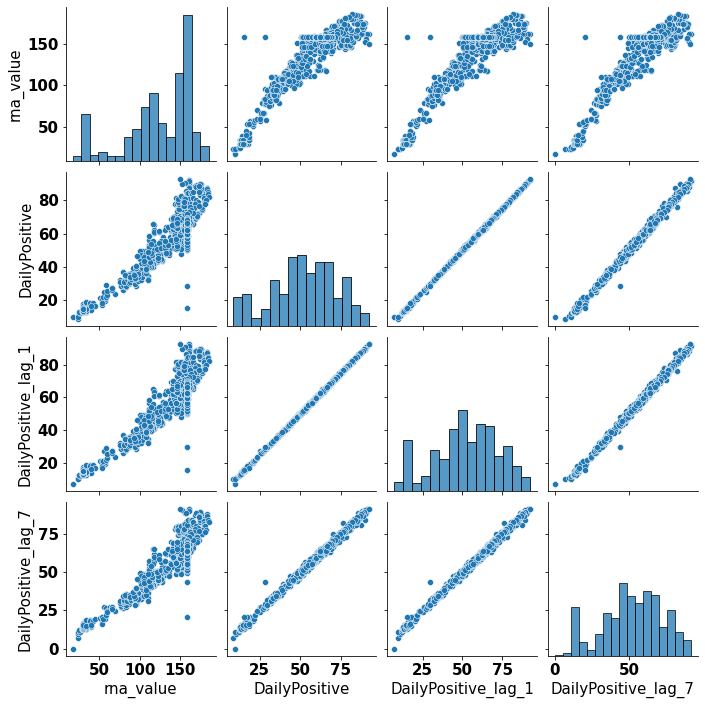

In [16]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
df2=df.iloc[:, [0,1,38,44]]
sns.pairplot(data=df2)
#sns.set(font_scale=2)
plt.savefig('correl.png',bbox_inches='tight')

Creating a linear model with RNA value, it's 7 lags and 13 dummy variables of 14 health regions and fitting Ordinary Least Square Regression

In [17]:
expr = 'DailyPositive ~ rna_value+rna_lag_1+rna_lag_2+rna_lag_3+rna_lag_4+rna_lag_5+rna_lag_6+rna_lag_7+NHS_Borders+NHS_Dumfries_and_Galloway+NHS_Fife+NHS_Forth_Valley+NHS_Grampian+NHS_Greater_Glasgow_and_Clyde+NHS_Highland+NHS_Lanarkshire+NHS_Lothian+NHS_Orkney+NHS_Shetland+NHS_Tayside+NHS_Western_Isles+weekday'

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
olsr_results = linear_model.OLS(y_train, X_train).fit()
olsr_results.summary()
print(olsr_results.summary())

#Converting to latex table
for table in olsr_results.summary().tables:
    print(table.as_latex_tabular())

                            OLS Regression Results                            
Dep. Variable:          DailyPositive   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     355.0
Date:                Tue, 06 Sep 2022   Prob (F-statistic):          7.01e-317
Time:                        03:17:12   Log-Likelihood:                -2427.5
No. Observations:                 723   AIC:                             4887.
Df Residuals:                     707   BIC:                             4960.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [18]:
y_pred=olsr_results.predict(X_test)
y_pred=pd.DataFrame(y_pred)
pred=pd.concat([y_test, y_pred], axis=1)
mapping = {pred.columns[0]:'DailyPositive_actual', pred.columns[1]: 'DailyPositive_predictions'}
pred = pred.rename(columns=mapping)
pred

DailyPositive_actual  DailyPositive_predictions
DateTimeIndex                                                 
2022-05-21                51.063301                  68.757134
2022-05-22                50.793021                  70.419688
2022-05-23                52.954498                  70.142596
2022-05-24                54.461613                  69.865503
2022-05-25                54.038988                  69.588411
2022-05-26                52.805256                  69.311319
2022-05-27                52.279854                  69.034226
2022-05-28                51.734501                  68.757134
2022-05-29                53.319064                  70.419688
2022-05-30                56.563254                  70.142596
2022-05-31                58.172826                  69.865503
2022-06-01                58.314671                  69.588411
2022-06-02                55.236470                  69.311319
2022-06-03                54.746004                  69.034226
2022-06-04                57.215596                  68.757134
2022-06-05                59.029942                  70.419688
2022-06-06                62.554559                  70.142596
2022-06-07                62.858517                  69.865503
2022-06-08                61.612132                  69.588411
2022-06-09                61.125286                  69.311319
2022-06-10                59.591185                  69.034226
2022-06-11                59.720655                  68.757134
2022-06-12                62.289140                  70.419688
2022-06-13                64.227254                  70.142596
2022-06-14                65.823853                  69.865503
2022-06-15                65.550301                  69.588411
2022-06-16                64.133752                  69.311319
2022-06-17                64.189039                  69.034226
2022-06-18                62.162152                  68.757134
2022-06-19                65.724459                  70.419688
2022-06-20                67.729498                  70.142596
2022-06-21                68.961679                  69.865503
2022-06-22                68.057953                  69.588411
2022-06-23                66.370749                  69.311319
2022-06-24                61.977832                  69.034226
2022-06-25                28.453433                  68.757134
2022-06-26                15.380572                  70.419688

<AxesSubplot:xlabel='DateTimeIndex'>

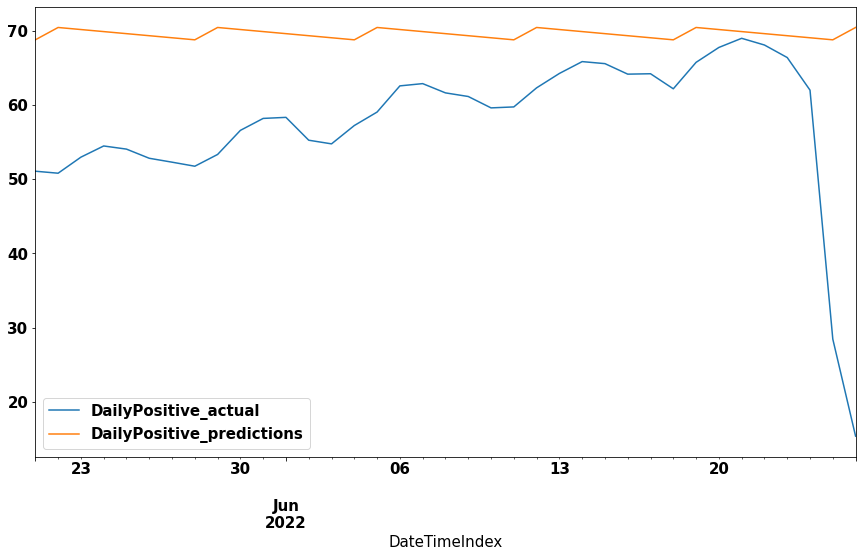

In [19]:
pred.plot(use_index=True)

Checking the stationarity of the residuals

In [20]:
adf_rez =statsmodels.tsa.stattools.adfuller(olsr_results.resid)
print("p-value for Dickey-Fuller test of stationarity is {0:.4f}, meaning that the time series is non-stationary".format(adf_rez[1]))

p-value for Dickey-Fuller test of stationarity is 0.2262, meaning that the time series is non-stationary


decomposing the residuals

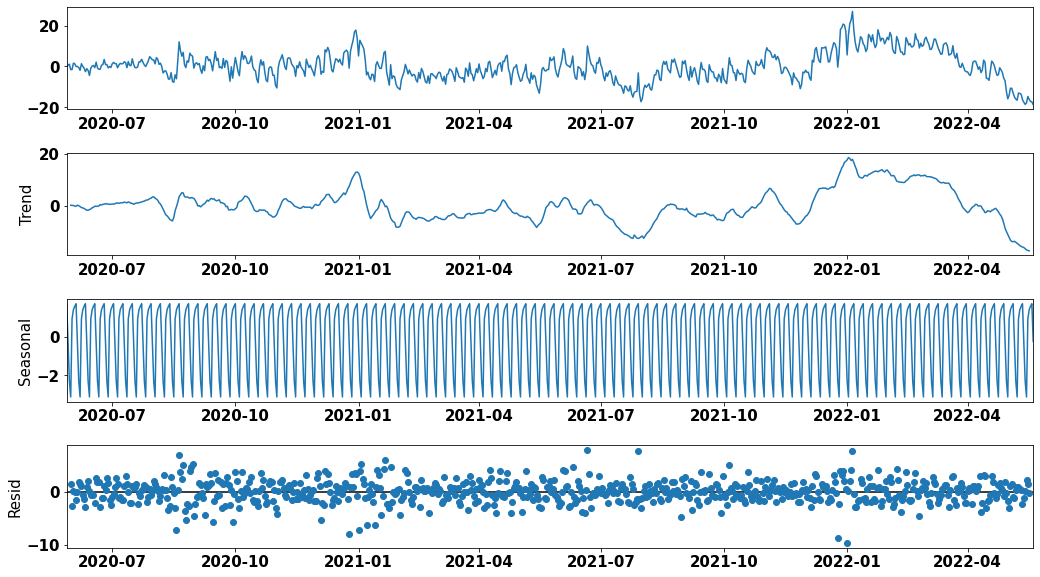

In [21]:
residual=olsr_results.resid
components = seasonal_decompose(residual)
components.plot()
plt.savefig('seasonal_decomp.png')

Plotting ACF and PACF of the residuals

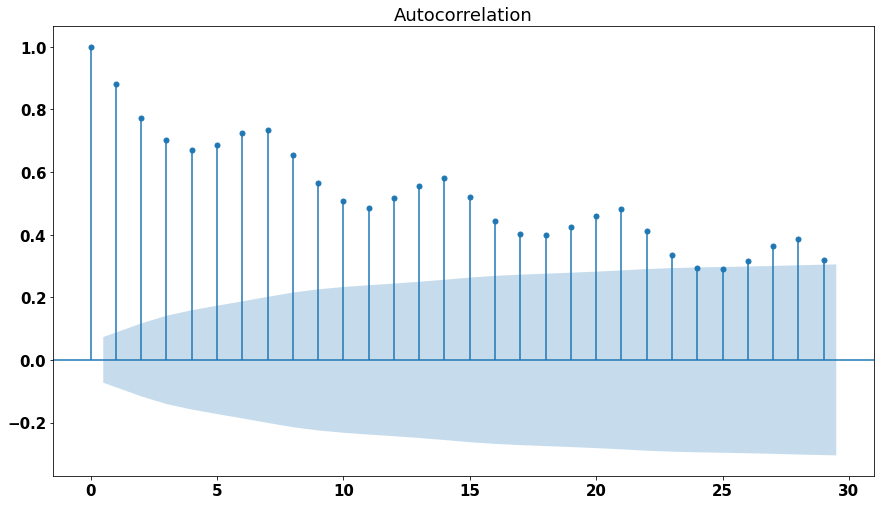

In [22]:
tsa.plot_acf(residual, alpha=0.05)

plt.savefig('ACF.png')

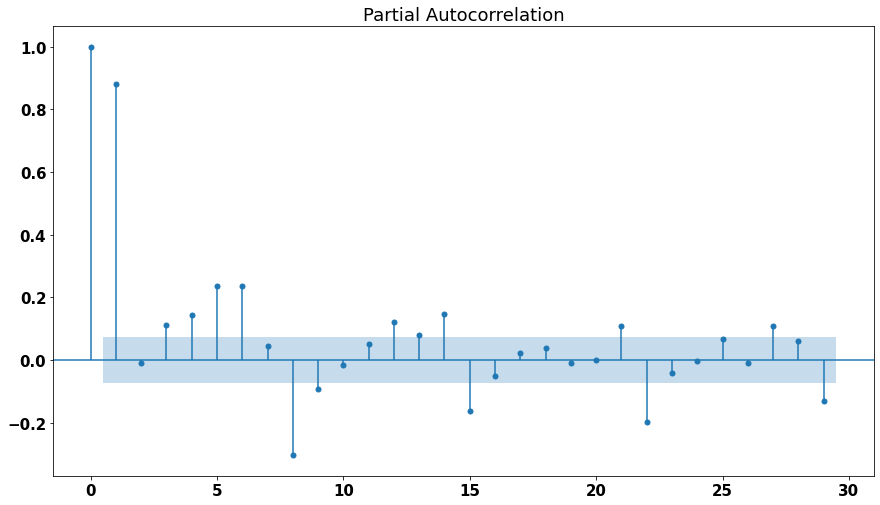

In [23]:
tsa.plot_pacf(olsr_results.resid, alpha=0.05)

plt.savefig('PACF.png')

In [24]:
olsr_resid_diff_1 = residual.diff()
olsr_resid_diff_1 = olsr_resid_diff_1.dropna()

In [25]:
adf_rez =statsmodels.tsa.stattools.adfuller(olsr_resid_diff_1)
print("p-value for Dickey-Fuller test of stationarity is {0:.4f}, meaning that the time series is stationary".format(adf_rez[1]))

p-value for Dickey-Fuller test of stationarity is 0.0000, meaning that the time series is stationary


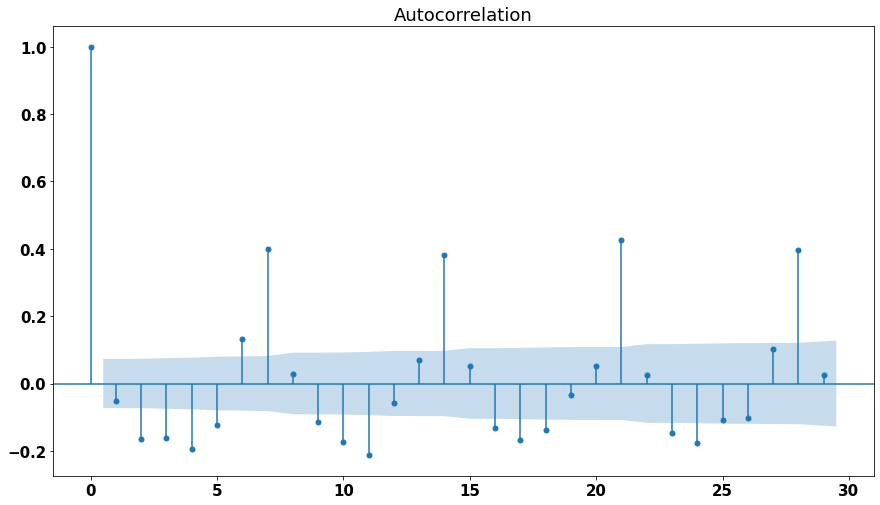

In [26]:
tsa.plot_acf(olsr_resid_diff_1, alpha=0.05)

plt.savefig('ACF_diff.png')
#Since lag-1 correlation is negative no further differencing is needed
#strong negative correlation at lag=1 p cannot be 1 ............so d=1, q=0,p=0

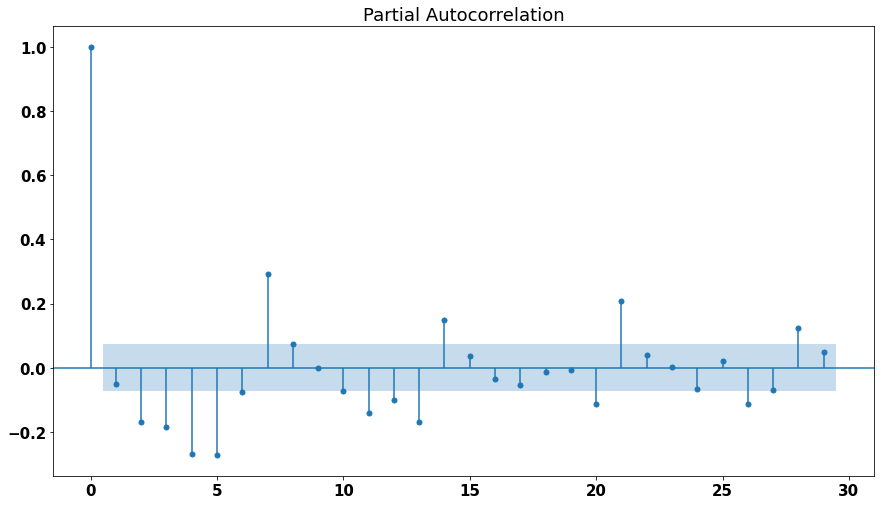

In [27]:
tsa.plot_pacf(olsr_resid_diff_1, alpha=0.05)
plt.savefig('PACF_diff.png')

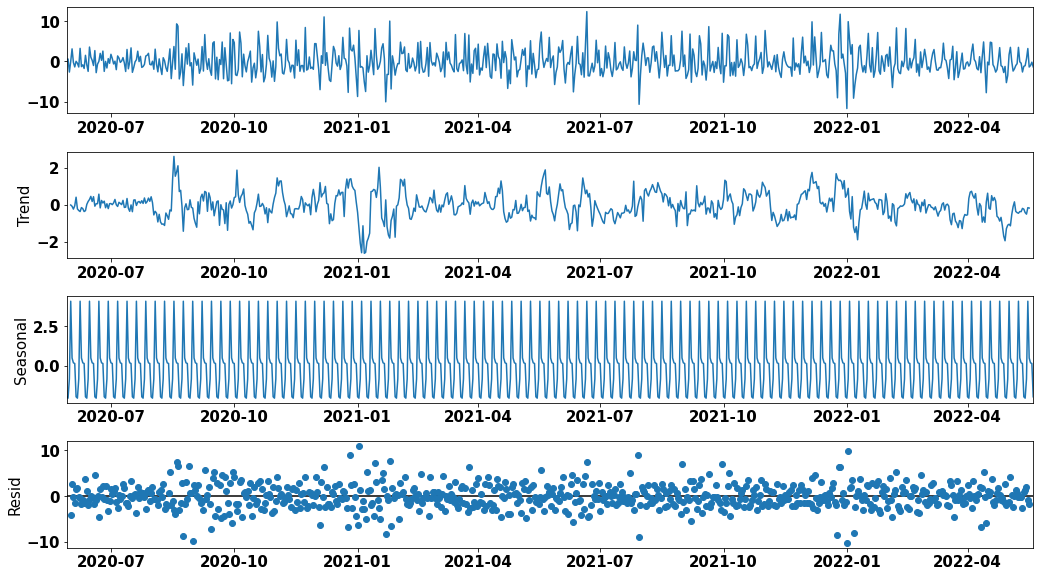

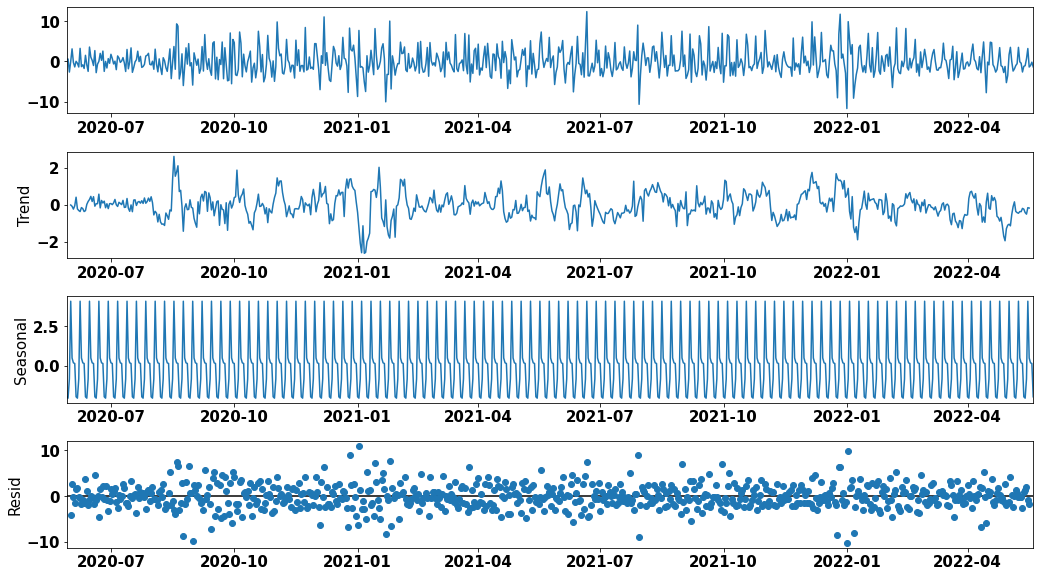

In [28]:
components = seasonal_decompose(olsr_resid_diff_1)
components.plot()

<AxesSubplot:xlabel='DateTimeIndex'>

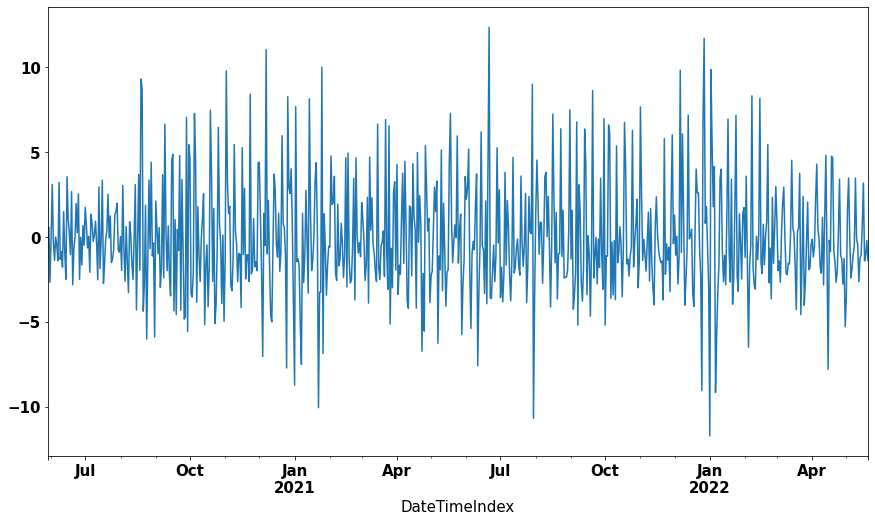

In [29]:
olsr_resid_diff_1.plot()

<AxesSubplot:xlabel='DateTimeIndex'>

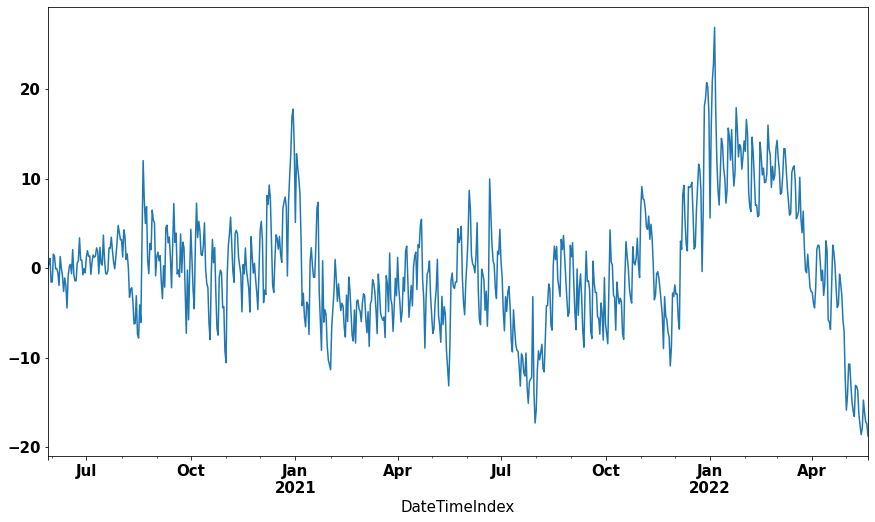

In [30]:
olsr_results.resid.plot()

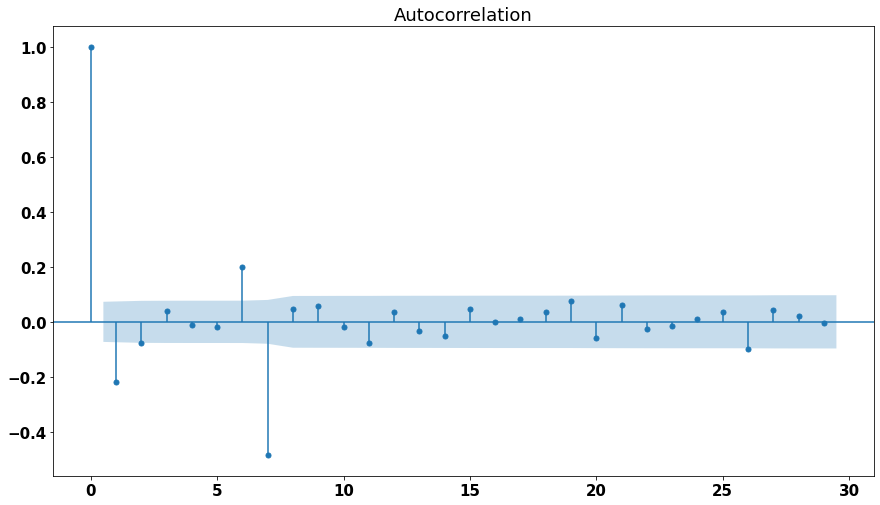

In [31]:
#since data given is weekly find any weekly changes
olsr_resid_diff_1_7=olsr_resid_diff_1.diff(periods=7)
olsr_resid_diff_1_7=olsr_resid_diff_1_7.fillna(0)
tsa.plot_acf(olsr_resid_diff_1_7, alpha=0.05)
plt.savefig('ACF_weekly_diff.png')
#strong negative correlation at lag=7 p cannot be 1............so D=1, Q=1,P=0

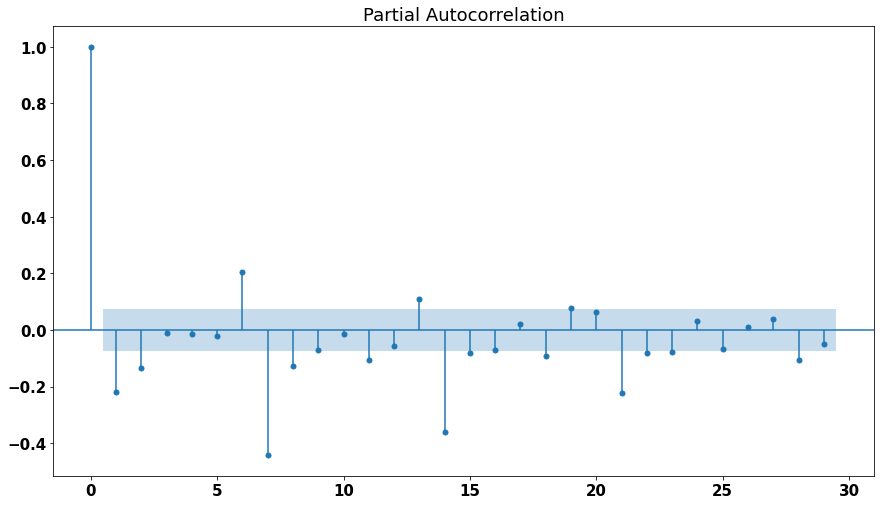

In [32]:
tsa.plot_pacf(olsr_resid_diff_1_7, alpha=0.05)
plt.savefig('PACF_weekly_diff.png')

In [33]:
olsr_resid_diff_1_7

DateTimeIndex
2020-05-29    0.000000
2020-05-30    0.000000
2020-05-31    0.000000
2020-06-01    0.000000
2020-06-02    0.000000
                ...   
2022-05-16   -0.288356
2022-05-17   -1.291061
2022-05-18   -0.582360
2022-05-19    2.437515
2022-05-20   -0.144211
Length: 722, dtype: float64

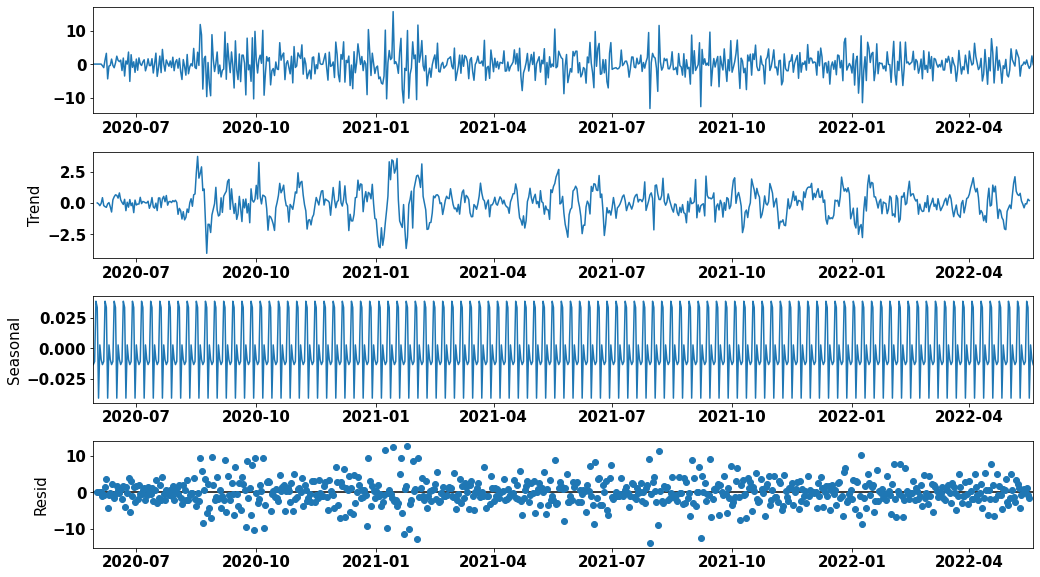

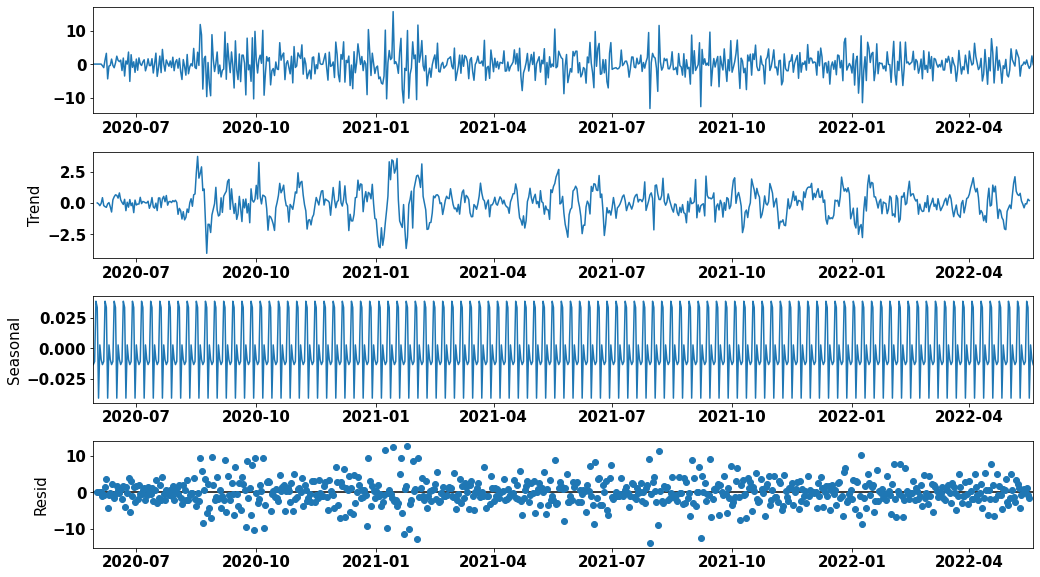

In [34]:
components = seasonal_decompose(olsr_resid_diff_1_7)
components.plot()

In [35]:
X_train

Intercept   rna_value   rna_lag_1   rna_lag_2   rna_lag_3  \
DateTimeIndex                                                              
2020-05-28           1.0   16.907462   14.604877    6.907755    4.605170   
2020-05-29           1.0   23.188833   18.017214   23.411750   19.210047   
2020-05-30           1.0   23.188833   23.188833   23.188833   23.188833   
2020-05-31           1.0   23.188833   23.188833   23.188833   23.188833   
2020-06-01           1.0   25.491418   25.491418   25.491418   29.693122   
...                  ...         ...         ...         ...         ...   
2022-05-16           1.0  157.947298  157.947298  157.947298  157.947298   
2022-05-17           1.0  157.947298  157.947298  157.947298  157.947298   
2022-05-18           1.0  157.947298  157.947298  157.947298  157.947298   
2022-05-19           1.0  157.947298  157.947298  157.947298  157.947298   
2022-05-20           1.0  157.947298  157.947298  157.947298  157.947298   

                rna_lag_4   rna_lag_5   rna_lag_6   rna_lag_7  NHS_Borders  \
DateTimeIndex                                                                
2020-05-28       2.302585    0.000000    0.000000    0.000000          0.0   
2020-05-29      19.210047   19.210047   16.907462   14.604877          0.0   
2020-05-30      23.188833   23.188833   23.188833   18.017214          0.0   
2020-05-31      23.188833   23.188833   23.188833   23.188833          0.0   
2020-06-01      25.491418   25.491418   25.491418   30.663038          0.0   
...                   ...         ...         ...         ...          ...   
2022-05-16     157.947298  157.947298  157.947298  157.947298          1.0   
2022-05-17     157.947298  157.947298  157.947298  157.947298          1.0   
2022-05-18     157.947298  157.947298  157.947298  157.947298          1.0   
2022-05-19     157.947298  157.947298  157.947298  157.947298          1.0   
2022-05-20     157.947298  157.947298  157.947298  157.947298          1.0   

               ...  NHS_Grampian  NHS_Greater_Glasgow_and_Clyde  NHS_Highland  \
DateTimeIndex  ...                                                              
2020-05-28     ...           1.0                            1.0           0.0   
2020-05-29     ...           1.0                            1.0           0.0   
2020-05-30     ...           1.0                            1.0           0.0   
2020-05-31     ...           1.0                            1.0           0.0   
2020-06-01     ...           1.0                            1.0           1.0   
...            ...           ...                            ...           ...   
2022-05-16     ...           1.0                            1.0           1.0   
2022-05-17     ...           1.0                            1.0           1.0   
2022-05-18     ...           1.0                            1.0           1.0   
2022-05-19     ...           1.0                            1.0           1.0   
2022-05-20     ...           1.0                            1.0           1.0   

               NHS_Lanarkshire  NHS_Lothian  NHS_Orkney  NHS_Shetland  \
DateTimeIndex                                                           
2020-05-28                 1.0          0.0         0.0           0.0   
2020-05-29                 1.0          0.0         0.0           0.0   
2020-05-30                 1.0          0.0         0.0           0.0   
2020-05-31                 1.0          0.0         0.0           0.0   
2020-06-01                 1.0          0.0         0.0           0.0   
...                        ...          ...         ...           ...   
2022-05-16                 1.0          1.0         1.0           1.0   
2022-05-17                 1.0          1.0         1.0           1.0   
2022-05-18                 1.0          1.0         1.0           1.0   
2022-05-19                 1.0          1.0         1.0           1.0   
2022-05-20                 1.0          1.0         1.0           1.0   

       

In [36]:

X_train_minus_intercept = X_train.drop('Intercept', axis=1)
X_train_minus_intercept = X_train_minus_intercept.asfreq('D')

#y_train = y_train.asfreq('D')



In [37]:
warnings.simplefilter('ignore', ConvergenceWarning)
sarimax_model = ARIMA(endog=y_train, exog=X_train_minus_intercept,order=(0,1,1), seasonal_order=(1,1,0,7))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()
#print(sarimax_results.mle_retvals)
for table in sarimax_results.summary().tables:
    print(table.as_latex_tabular())
#p value of ljung-box test decreased and skewness and kurtosis decreased than previous model so this is the best model

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &        DailyPositive         & \textbf{  No. Observations:  } &    723     \\
\textbf{Model:}           & ARIMA(0, 1, 1)x(1, 1, [], 7) & \textbf{  Log Likelihood     } & -1434.404  \\
\textbf{Date:}            &       Tue, 06 Sep 2022       & \textbf{  AIC                } &  2918.808  \\
\textbf{Time:}            &           03:17:21           & \textbf{  BIC                } &  3033.115  \\
\textbf{Sample:}          &          05-28-2020          & \textbf{  HQIC               } &  2962.951  \\
\textbf{}                 &         - 05-20-2022         & \textbf{                     } &            \\
\textbf{Covariance Type:} &             opg              & \textbf{                     } &            \\
\bottomrule
\end{tabular}
%\caption{SARIMAX Results}
\end{center}
\begin{center}
\begin{tabular}{lcccccc}
\toprule
                                           & \textbf{coef} & \textbf{std err} & \textbf{z} & \tex

Since p-value of Heteroskedasticity is greater than 0.05 we cannot reject the null hypothesis that heteroskedasticity is not present at 95% confidence interval.

In [38]:
X_test_minus_intercept = X_test.drop('Intercept', axis=1)
X_test_minus_intercept = X_test_minus_intercept.asfreq('D')
y_test = y_test.asfreq('D')

In [39]:
predictions = sarimax_results.get_forecast(steps=36, exog=X_test_minus_intercept[:36])

y_pred=predictions.predicted_mean
y_pred
predictions.summary_frame()
#print(predictions.summary_frame().to_latex())

DailyPositive       mean    mean_se  mean_ci_lower  mean_ci_upper
2022-05-21     48.715673   1.797683      45.192278      52.239067
2022-05-22     50.626651   2.164143      46.385008      54.868294
2022-05-23     53.641279   2.476968      48.786511      58.496046
2022-05-24     52.393304   2.754491      46.994601      57.792008
2022-05-25     51.272581   3.006505      45.379939      57.165223
2022-05-26     49.981727   3.238970      43.633462      56.329991
2022-05-27     48.382843   3.455832      41.609536      55.156150
2022-05-28     46.897062   4.208374      38.648800      55.145325
2022-05-29     48.944921   4.662458      39.806672      58.083170
2022-05-30     51.927317   5.076082      41.978379      61.876255
2022-05-31     50.535031   5.458453      39.836661      61.233402
2022-06-01     49.349214   5.815737      37.950578      60.747849
2022-06-02     48.330818   6.152308      36.272515      60.389121
2022-06-03     46.715815   6.471398      34.032107      59.399522
2022-06-04     45.205795   7.312345      30.873862      59.537729
2022-06-05     47.207891   7.882653      31.758174      62.657608
2022-06-06     50.201063   8.414396      33.709150      66.692976
2022-06-07     48.857025   8.914477      31.384972      66.329078
2022-06-08     47.692970   9.387957      29.292914      66.093027
2022-06-09     46.583483   9.838677      27.300031      65.866935
2022-06-10     44.973870  10.269635      24.845755      65.101984
2022-06-11     43.471954  11.123587      21.670124      65.273783
2022-06-12     45.489349  11.766281      22.427861      68.550837
2022-06-13     48.478919  12.375644      24.223102      72.734736
2022-06-14     47.118750  12.956379      21.724713      72.512786
2022-06-15     45.947419  13.512178      19.464037      72.430801
2022-06-16     44.868387  14.046001      17.338731      72.398043
2022-06-17     43.256971  14.560266      14.719375      71.794567
2022-06-18     41.752346  15.457064      11.457058      72.047634
2022-06-19     43.764626  16.168189      12.075559      75.453694
2022-06-20     46.755400  16.849327      13.731326      79.779475
2022-06-21     45.400624  17.503980      11.093454      79.707795
2022-06-22     44.231726  18.135017       8.687747      79.775706
2022-06-23     43.142512  18.744821       6.403337      79.881687
2022-06-24     41.531699  19.335404       3.635004      79.428393
2022-06-25     40.027980  20.271105       0.297343      79.758616

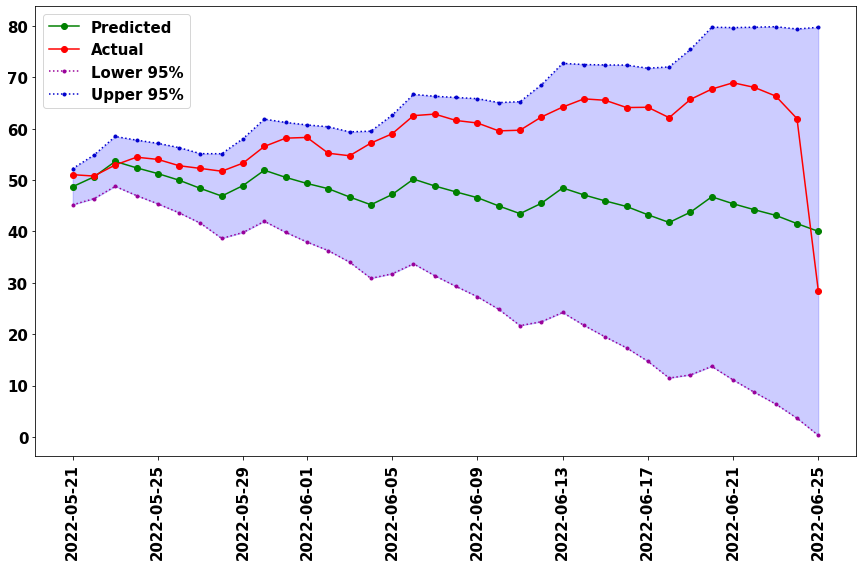

In [40]:
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

plt.rc('font', **font)
predicted, = plt.plot(X_test_minus_intercept[:36].index, predictions.summary_frame()['mean'], 'go-', label='Predicted')
 
actual, = plt.plot(X_test_minus_intercept[:36].index, y_test[:36], 'ro-', label='Actual')
 
lower, = plt.plot(X_test_minus_intercept[:36].index, predictions.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
 
upper, = plt.plot(X_test_minus_intercept[:36].index, predictions.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')

plt.fill_between(X_test_minus_intercept[:36].index, predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
 
plt.legend(handles=[predicted, actual, lower, upper])

plt.xticks(rotation=90)

plt.savefig('pred_act.png',bbox_inches='tight')

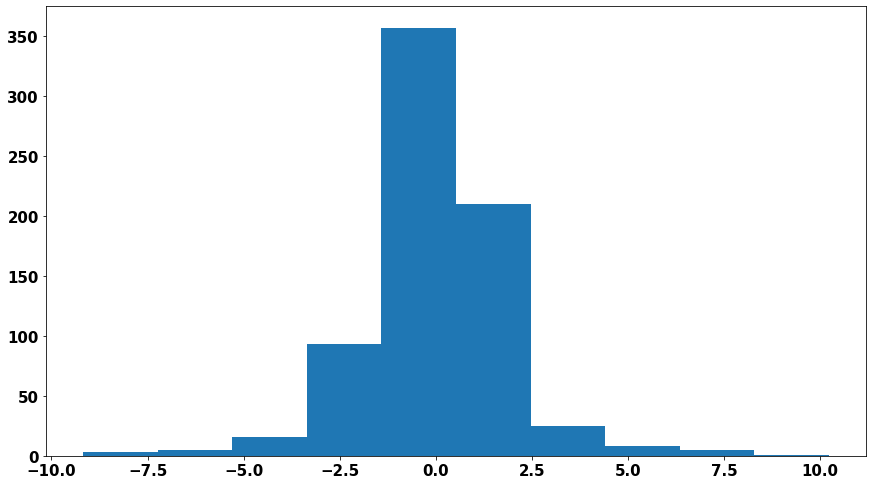

In [41]:
pyplot.hist(sarimax_results.resid)
plt.savefig('hist.png')

C:\Users\simon\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



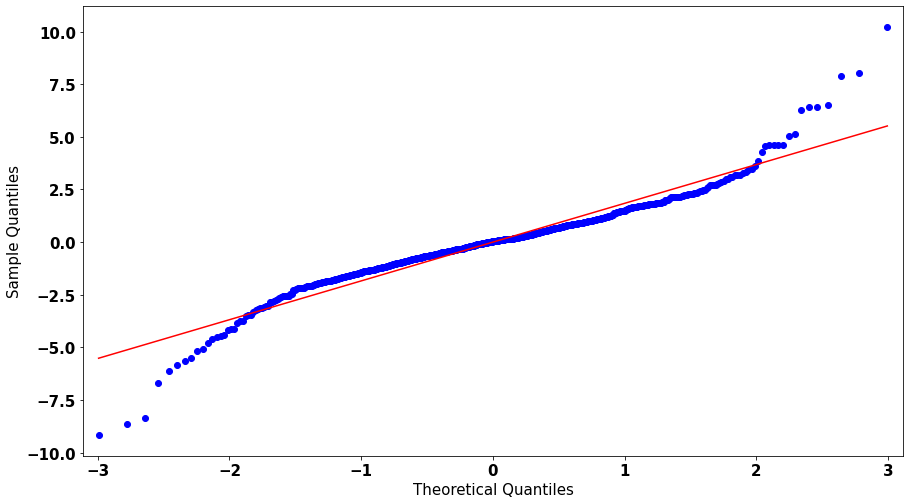

In [42]:
qqplot(sarimax_results.resid, line='s')
plt.savefig('qq.png')

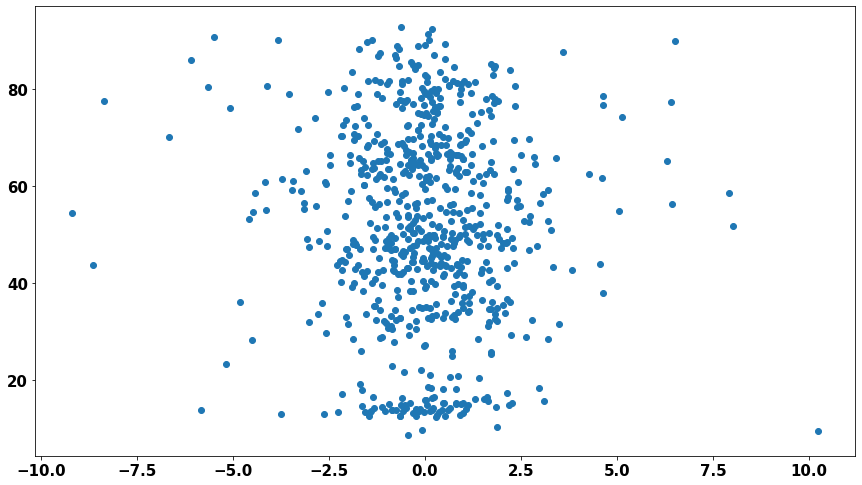

In [43]:
pyplot.scatter(sarimax_results.resid,y_train)

# Early Detection

Importing file with daily cases in Scotland

In [44]:
df_cum=pd.read_csv('covid_daily_cumulative_cases.csv', header=0)
df_cum

Country      Date  DailyCases  CumulativeCases
0    S92000003  20200301           2                3
1    S92000003  20200302           1                4
2    S92000003  20200303           3                7
3    S92000003  20200304           6               13
4    S92000003  20200305           2               15
..         ...       ...         ...              ...
871  S92000003  20220720        1478          2063588
872  S92000003  20220721        1225          2064813
873  S92000003  20220722        1058          2065871
874  S92000003  20220723         918          2066789
875  S92000003  20220724         923          2067712

[876 rows x 4 columns]

In [45]:
ts = ewstools.core.TimeSeries(data=df_cum["DailyCases"],transition=668)
ts
ts.detrend(method='Lowess', span=0.1)
#ts.state.plot()
ts.compute_var(rolling_window=0.5)
ts.compute_auto(lag=1, rolling_window=0.5)
ts.compute_skew(rolling_window=0.5)
ts.compute_cv(rolling_window=0.5)
ts.ews.dropna()
ts.compute_ktau()
ts.ktau
ts.make_plotly()
fig=ts.make_plotly(kendall_tau=True)
fig
#plt.savefig('ew.png')

In [46]:
expr = 'DailyPositive ~ rna_lag_7+NHS_Borders+NHS_Dumfries_and_Galloway+NHS_Fife+NHS_Forth_Valley+NHS_Grampian+NHS_Greater_Glasgow_and_Clyde+NHS_Highland+NHS_Lanarkshire+NHS_Lothian+NHS_Orkney+NHS_Shetland+NHS_Tayside+NHS_Western_Isles'

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
olsr_results = linear_model.OLS(y_train, X_train).fit()
olsr_results.summary()
print(olsr_results.summary())
for table in olsr_results.summary().tables:
    print(table.as_latex_tabular())

                            OLS Regression Results                            
Dep. Variable:          DailyPositive   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     749.6
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        03:17:23   Log-Likelihood:                -2435.8
No. Observations:                 723   AIC:                             4888.
Df Residuals:                     715   BIC:                             4924.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [47]:
olsr_results.predict(X_test)

DateTimeIndex
2022-05-21    69.569319
2022-05-22    69.569319
2022-05-23    69.569319
2022-05-24    69.569319
2022-05-25    69.569319
2022-05-26    69.569319
2022-05-27    69.569319
2022-05-28    69.569319
2022-05-29    69.569319
2022-05-30    69.569319
2022-05-31    69.569319
2022-06-01    69.569319
2022-06-02    69.569319
2022-06-03    69.569319
2022-06-04    69.569319
2022-06-05    69.569319
2022-06-06    69.569319
2022-06-07    69.569319
2022-06-08    69.569319
2022-06-09    69.569319
2022-06-10    69.569319
2022-06-11    69.569319
2022-06-12    69.569319
2022-06-13    69.569319
2022-06-14    69.569319
2022-06-15    69.569319
2022-06-16    69.569319
2022-06-17    69.569319
2022-06-18    69.569319
2022-06-19    69.569319
2022-06-20    69.569319
2022-06-21    69.569319
2022-06-22    69.569319
2022-06-23    69.569319
2022-06-24    69.569319
2022-06-25    69.569319
2022-06-26    69.569319
dtype: float64

In [48]:
adf_rez =statsmodels.tsa.stattools.adfuller(olsr_results.resid)
print("p-value for Dickey-Fuller test of stationarity is {0:.4f}, meaning that the time series is non-stationary".format(adf_rez[1]))

p-value for Dickey-Fuller test of stationarity is 0.3111, meaning that the time series is non-stationary


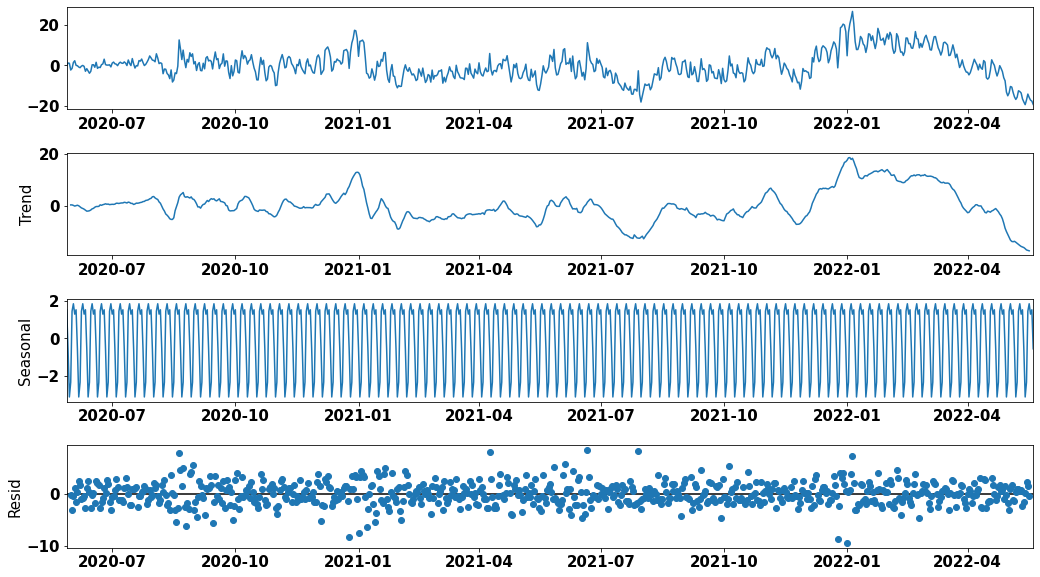

In [49]:
residual=olsr_results.resid
components = seasonal_decompose(residual)
components.plot()
plt.show()
#plt.savefig('seasonal_decomp.png')

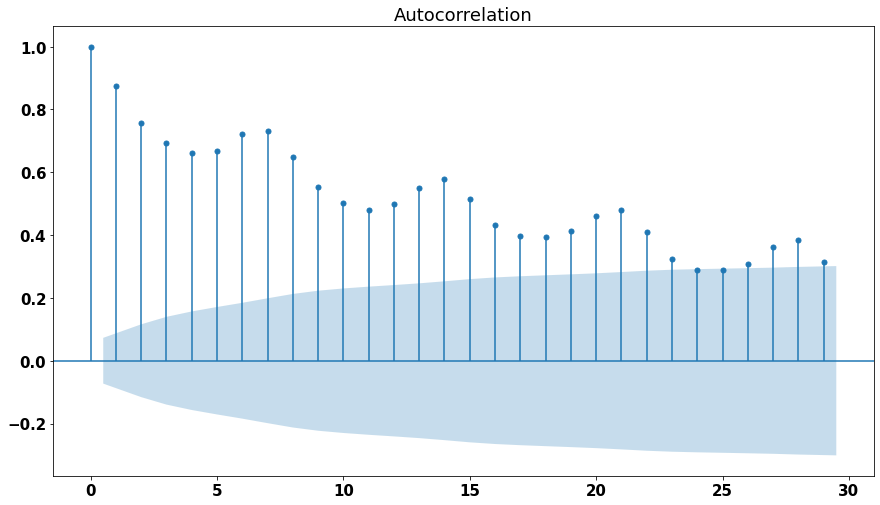

In [50]:
tsa.plot_acf(residual, alpha=0.05)

plt.show()

In [51]:
olsr_resid_diff_1 = residual.diff()
olsr_resid_diff_1 = olsr_resid_diff_1.dropna()

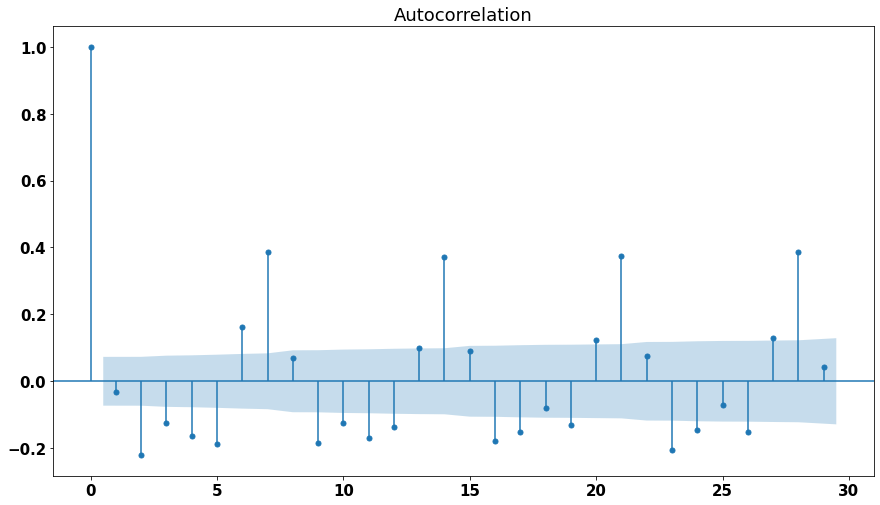

In [52]:
tsa.plot_acf(olsr_resid_diff_1, alpha=0.05)
plt.show()

In [53]:
adf_rez =statsmodels.tsa.stattools.adfuller(olsr_resid_diff_1)
print("p-value for Dickey-Fuller test of stationarity is {0:.4f}, meaning that the time series is stationary".format(adf_rez[1]))

p-value for Dickey-Fuller test of stationarity is 0.0000, meaning that the time series is stationary


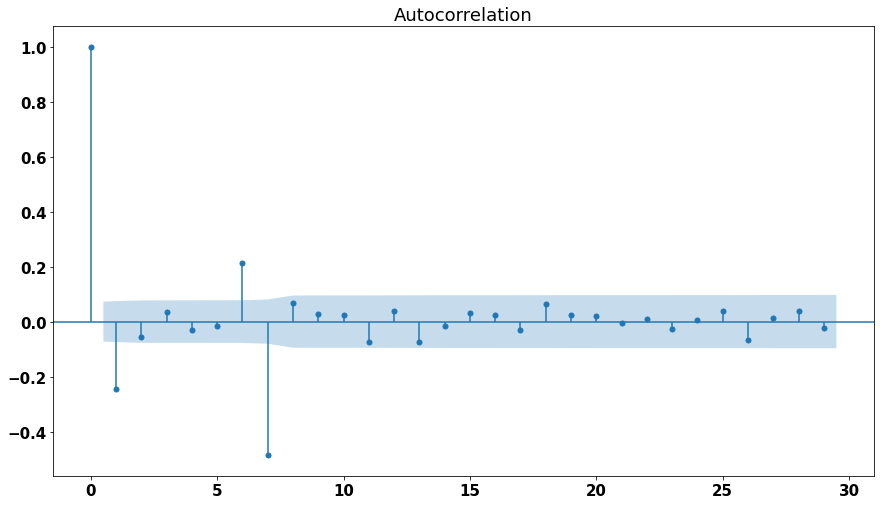

In [54]:
#since data given is weekly find any weekly changes
olsr_resid_diff_1_7=olsr_resid_diff_1.diff(periods=7)
olsr_resid_diff_1_7=olsr_resid_diff_1_7.fillna(0)
tsa.plot_acf(olsr_resid_diff_1_7, alpha=0.05)
plt.show()

In [55]:
X_train_minus_intercept = X_train.drop('Intercept', axis=1)
X_train_minus_intercept = X_train_minus_intercept.asfreq('D')


In [56]:
warnings.simplefilter('ignore', ConvergenceWarning)
sarimax_model = ARIMA(endog=y_train, exog=X_train_minus_intercept,order=(0,1,1), seasonal_order=(1,1,0,7))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()
for table in sarimax_results.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &        DailyPositive         & \textbf{  No. Observations:  } &    723     \\
\textbf{Model:}           & ARIMA(0, 1, 1)x(1, 1, [], 7) & \textbf{  Log Likelihood     } & -1437.931  \\
\textbf{Date:}            &       Tue, 06 Sep 2022       & \textbf{  AIC                } &  2909.862  \\
\textbf{Time:}            &           03:17:26           & \textbf{  BIC                } &  2987.591  \\
\textbf{Sample:}          &          05-28-2020          & \textbf{  HQIC               } &  2939.879  \\
\textbf{}                 &         - 05-20-2022         & \textbf{                     } &            \\
\textbf{Covariance Type:} &             opg              & \textbf{                     } &            \\
\bottomrule
\end{tabular}
%\caption{SARIMAX Results}
\end{center}
\begin{center}
\begin{tabular}{lcccccc}
\toprule
                                           & \textbf{coef} & \textbf{std err} & \textbf{z} & \tex

In [57]:
X_test_minus_intercept = X_test.drop('Intercept', axis=1)
X_test_minus_intercept = X_test_minus_intercept.asfreq('D')
y_test = y_test.asfreq('D')

In [58]:
predictions = sarimax_results.get_forecast(steps=36, exog=X_test_minus_intercept[:36])

y_pred=predictions.predicted_mean
y_pred
predictions.summary_frame()
#print(predictions.summary_frame().to_latex())

DailyPositive       mean    mean_se  mean_ci_lower  mean_ci_upper
2022-05-21     48.708800   1.806701      45.167732      52.249868
2022-05-22     50.620991   2.168731      46.370357      54.871625
2022-05-23     53.635333   2.478431      48.777698      58.492969
2022-05-24     52.386080   2.753515      46.989290      57.782871
2022-05-25     51.264780   3.003510      45.378009      57.151551
2022-05-26     49.976340   3.234238      43.637349      56.315330
2022-05-27     48.377314   3.449569      41.616284      55.138344
2022-05-28     46.886736   4.204684      38.645706      55.127766
2022-05-29     48.934998   4.655877      39.809648      58.060348
2022-05-30     51.917299   5.067051      41.986063      61.848536
2022-05-31     50.524589   5.447276      39.848124      61.201054
2022-06-01     49.338579   5.802640      37.965614      60.711545
2022-06-02     48.320986   6.137463      36.291780      60.350191
2022-06-03     46.705935   6.454941      34.054484      59.357387
2022-06-04     45.190499   7.297806      30.887062      59.493937
2022-06-05     47.193403   7.864968      31.778348      62.608458
2022-06-06     50.186385   8.393895      33.734652      66.638118
2022-06-07     48.841495   8.891413      31.414645      66.268345
2022-06-08     47.677055   9.362531      29.326832      66.027279
2022-06-09     46.569177   9.811052      27.339869      65.798485
2022-06-10     44.959469  10.239946      24.889544      65.029393
2022-06-11     43.452319  11.094882      21.706750      65.197888
2022-06-12     45.470342  11.734470      22.471203      68.469482
2022-06-13     48.459764  12.340956      24.271935      72.647593
2022-06-14     47.098933  12.919001      21.778156      72.419710
2022-06-15     45.927304  13.472267      19.522145      72.332463
2022-06-16     44.849521  14.003692      17.402790      72.296253
2022-06-17     43.238032  14.515674      14.787834      71.688229
2022-06-18     41.728120  15.412837      11.519515      71.936726
2022-06-19     43.741104  16.120723      12.145067      75.337140
2022-06-20     46.731712  16.798806      13.806658      79.656766
2022-06-21     45.376195  17.450560      11.173726      79.578663
2022-06-22     44.206962  18.078833       8.773101      79.640823
2022-06-23     43.119147  18.685994       6.495273      79.743022
2022-06-24     41.508252  19.274038       3.731832      79.284671
2022-06-25     39.999261  20.209604       0.389165      79.609357

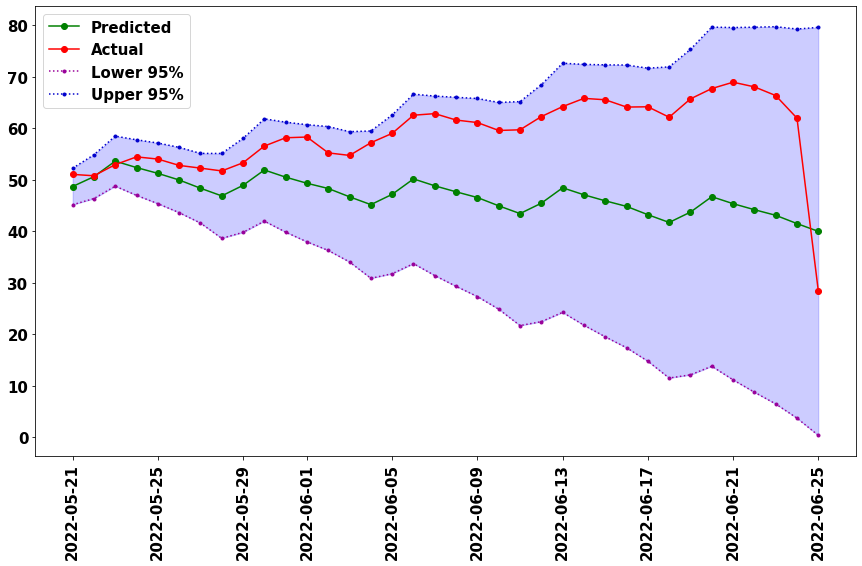

In [59]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
predicted, = plt.plot(X_test_minus_intercept[:36].index, predictions.summary_frame()['mean'], 'go-', label='Predicted')
 
actual, = plt.plot(X_test_minus_intercept[:36].index, y_test[:36], 'ro-', label='Actual')
 
lower, = plt.plot(X_test_minus_intercept[:36].index, predictions.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
 
upper, = plt.plot(X_test_minus_intercept[:36].index, predictions.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')

plt.fill_between(X_test_minus_intercept[:36].index, predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
 
plt.legend(handles=[predicted, actual, lower, upper])

plt.xticks(rotation=90)

plt.show()

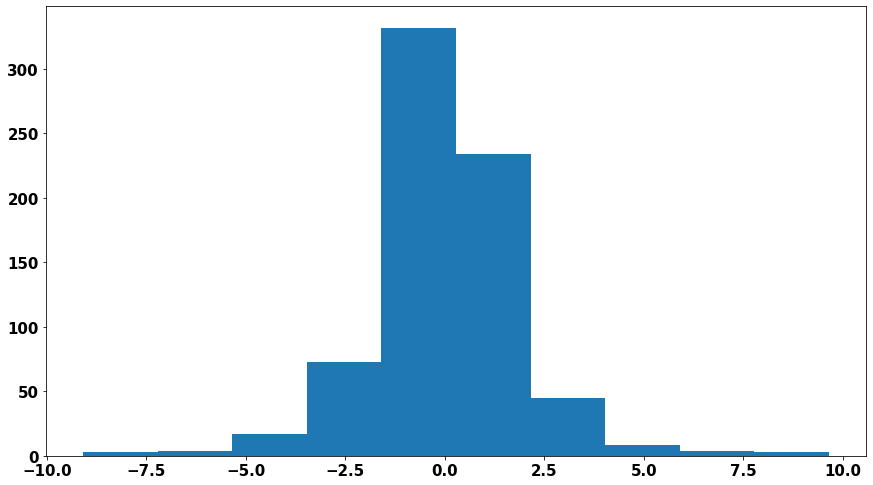

In [60]:
pyplot.hist(sarimax_results.resid)
plt.show()

C:\Users\simon\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



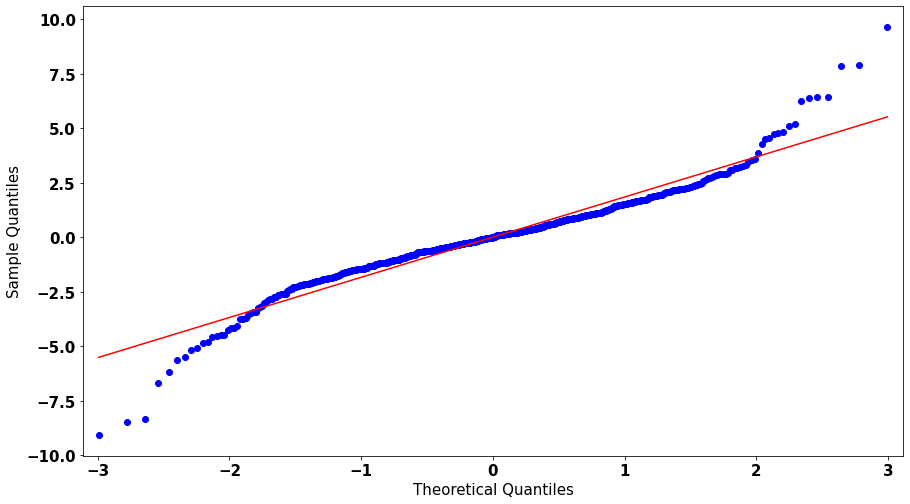

In [61]:
qqplot(sarimax_results.resid, line='s')
plt.show()